<a href="https://colab.research.google.com/github/mai0elkady/Boston_airbnb_data_analysis/blob/main/notebooks/scratch_tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [595]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [596]:
# paths for real datasets
bike_sharing_data_path = 'drive/My Drive/discrete_flows/data/bike_sahring_washigtong_dc_hour.csv'
mushroom_data_path = 'drive/My Drive/discrete_flows/data/agaricus-lepiota.data'

In [597]:
import numpy as np
import scipy.stats
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import figure
import pandas as pd
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import random
import graphviz
import collections
import copy
import math
import time




# Data Generation (synthetic datasets)

In [598]:
def get_all_k_length(k_values, d, answer): 
    k_len = len(k_values)  
    get_all_k_length_rec(k_values, [], k_len, d, answer) 
  
def get_all_k_length_rec(k_values, prefix, k_len, d, answer): 
    if (d == 0) : 
        answer.append(np.array(prefix))
        return

    for i in range(k_len): 
        newPrefix = prefix + [k_values[i]] 
        get_all_k_length_rec(k_values, newPrefix, k_len, d - 1, answer) 

def get_possible_k(k,d):
  answer = []
  k_values = list(range(0,k))
  get_all_k_length(k_values, d, answer)
  return np.array(answer)

def create_syn_data_paper(alpha,k,d,n_samples,rnd_seed,manual_prob,orig_probs,dirchlet_seed):
  if(manual_prob == False): # if manual prob is False ignore the passed original probs, 
  # and generate new ones from a dirchlet distrbuition
    np.random.seed(dirchlet_seed)
    orig_probs = np.random.dirichlet(np.ones(k**d)*alpha)
  np.random.seed(rnd_seed) # seed for random data
  X_train_coded = np.random.choice(k**d, size=n_samples, p=orig_probs) #for k=2 and d=2, X_train_coded = {0,1,2,3,2,3,0,...}
  return orig_probs,X_train_coded
  
def dec_to_bin(data,n_features,k):
  possible_bin_values = get_possible_k(k,n_features)
  result = possible_bin_values[data]
  return np.array(result)



In [599]:
alpha = 1
orig_probs, coded_data = create_syn_data_paper(alpha,k=2,d=2,n_samples=10000,rnd_seed=42,manual_prob=True,orig_probs=[1/3,1/6,1/6,1/3],dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=2,k=2)

In [600]:
alpha = 0.1
orig_probs, coded_data = create_syn_data_paper(alpha,k=2,d=4,n_samples=10000,rnd_seed=42,manual_prob=False,orig_probs=[1/3,1/6,1/6,1/3],dirchlet_seed=0)
print(sum(orig_probs))
print(orig_probs)

0.9999999999999999
[8.54322227e-04 2.18193788e-03 6.41941012e-05 8.87196921e-05
 3.48918588e-01 3.33516721e-02 1.20558511e-03 1.12761893e-12
 3.93406118e-18 2.80572248e-02 5.84610006e-01 1.50972085e-04
 1.84621511e-10 1.26313679e-09 5.16198487e-04 5.78820100e-07]


In [601]:
# just some sanity checks
def calculate_nll_test(data,k):
  counts = {}
  n,d = data.shape
  for i in range(0,d):
    unique_cats, counts_unique_cats = np.unique(data[:,i], return_counts=True, axis = 0)
    counts[i] = dict(zip(unique_cats, counts_unique_cats))

  #method 1
  total_nll = 0
  for i in range(0,n):
    p = 1
    for j in range(0,d):
      counts_d = counts[j]
      p_j = counts_d[data[i,j]]/n
      p = p * p_j
    total_nll = total_nll + np.log2(p)
  print(total_nll)

  #method 2
  p = 0
  for j in range(0,d):
    for i in range(0,k):
      counts_d = counts[j]
      p_j = counts_d[i] * np.log2(counts_d[i]/n)
      p = p + p_j
  print(p)
calculate_nll_test(data,k=2)

-19997.07642208489
-19997.076422085727


#Preprocessing Data (real datasets)

## bike data

In [602]:
def process_bike_sharing_data(bike_sharing_data_path):
  bike_sharing_data = pd.read_csv(bike_sharing_data_path)
  #print(bike_sharing_data.head())
  #print(bike_sharing_data.columns)
  #print(bike_sharing_data.dtypes)
  bike_sharing_data = bike_sharing_data.drop(['instant','dteday','temp', 'atemp','windspeed','hum','casual', 'registered'],axis = 1)
  #print(bike_sharing_data.describe())
  #print(bike_sharing_data.head())
  #'cnt' is between 1 and 977
  # we can divide it into categories 20 categories
  output_end = 19
  output_start = 0
  input_end = np.max(bike_sharing_data['cnt'])
  input_start = np.min(bike_sharing_data['cnt'])
  slope = (output_end - output_start) / (input_end - input_start)
  #bike_sharing_data['cnt_cat'] = output_start + round(slope * (bike_sharing_data['cnt'] - input_start))
  #print(bike_sharing_data.columns)
  #print(bike_sharing_data.describe())
  #print(bike_sharing_data['cnt_cat'])
  #print(bike_sharing_data['cnt'])
  #print(np.unique(bike_sharing_data['cnt_cat'])) 
  bike_sharing_data = bike_sharing_data.drop(['cnt'],axis = 1)
  return bike_sharing_data.to_numpy()
  

In [603]:
process_bike_sharing_data(bike_sharing_data_path)

array([[ 1,  0,  1, ...,  6,  0,  1],
       [ 1,  0,  1, ...,  6,  0,  1],
       [ 1,  0,  1, ...,  6,  0,  1],
       ...,
       [ 1,  1, 12, ...,  1,  1,  1],
       [ 1,  1, 12, ...,  1,  1,  1],
       [ 1,  1, 12, ...,  1,  1,  1]])

## Mushroom data

In [604]:
 def process_mushroom_data(mushroom_data_path):
  mushroom_data = pd.read_csv(mushroom_data_path,header=None)
  #print(mushroom_data.head())
  
  for col_id in mushroom_data.columns:
    #print(col_id)
    unique_col_data = np.unique(mushroom_data.iloc[:,col_id])
    #print(unique_col_data)
    mapper = {}
    for i,d in enumerate(unique_col_data):
      mapper[d] = i
    mushroom_data.iloc[:,col_id] = [ mapper[x] for x in mushroom_data.iloc[:,col_id]]
    unique_col_data = np.unique(mushroom_data.iloc[:,col_id])
    #print(unique_col_data)
  mushroom_data = mushroom_data.drop([11],axis = 1) #11 had missing data, so I dropped it
  #print(mushroom_data.head())
  #print(mushroom_data.dtypes)
  #print(len(mushroom_data))
  
  return mushroom_data.to_numpy()
  

In [605]:
process_mushroom_data(mushroom_data_path)

array([[1, 5, 2, ..., 2, 3, 5],
       [0, 5, 2, ..., 3, 2, 1],
       [0, 0, 2, ..., 3, 2, 3],
       ...,
       [0, 2, 2, ..., 0, 1, 2],
       [1, 3, 3, ..., 7, 4, 2],
       [0, 5, 2, ..., 4, 1, 2]])

# Entropy helper functions

In [606]:
#some of the code is used and modified from here:
#https://github.com/SebastianMantey/Decision-Tree-from-Scratch/blob/master/notebooks/Video%2008%20-%20Categorical%20Features.ipynb
def calculate_entropy(data):
  
  _, counts = np.unique(data, return_counts=True)

  probabilities = counts / counts.sum()
  entropy = sum(probabilities * -np.log2(probabilities))
    
  return entropy

In [607]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

# Likelihood helper functions

In [608]:
def cat_counter(X,cat_counter_all,dim=None):
  '''
  Function for counting the number of samples with value = 0,1,..k-1
  This can be done for all dimensions in X if dim is None
  or for a specific dimension if dim is a specific value
  '''
  d = X.shape[1]
  if(dim==None):
    for i in range(0,d):
      cat_count_i = np.unique(X[:,i], return_counts=True)
      cat_count_i_dict = dict(zip(*cat_count_i))
      cat_counter_all[i] = cat_count_i_dict
  else:
    cat_count_i = np.unique(X[:,dim], return_counts=True)
    cat_count_i_dict = dict(zip(*cat_count_i))
    cat_counter_all[dim] = cat_count_i_dict
  return cat_counter_all

In [609]:
def compute_avg_loglikelihood_all(X):
  counts = cat_counter(X,{})
  n,d = X.shape
  sum_samples_log_prob = 0
  for j,sample in enumerate(X):
    sample_prob = 1
    for i,item in enumerate(sample):
      sample_prob = sample_prob*(counts[i][item]/n)
    sum_samples_log_prob = sum_samples_log_prob + np.log(sample_prob) 
  avg_samples_log_prob = sum_samples_log_prob/n
  #return -1*avg_samples_log_prob
  return sum_samples_log_prob,avg_samples_log_prob

In [610]:
def compute_avg_nll_all(X):
  counts = cat_counter(X,{})
  n,d = X.shape
  sum_samples_log_prob = 0
  for j,sample in enumerate(X):
    sample_prob = 1
    for i,item in enumerate(sample):
      sample_prob = sample_prob*(counts[i][item]/n)
    sum_samples_log_prob = sum_samples_log_prob + np.log(sample_prob) 
  avg_samples_log_prob = sum_samples_log_prob/n
  #return -1*avg_samples_log_prob
  return -1*sum_samples_log_prob,-1*avg_samples_log_prob

In [611]:
def calculate_delta_nll(n,n_v_1,n_v_1_dash,n_v_2,n_v_2_dash,k):
  DEBUG_calc_nll = False
  delta_1 = n_v_1_dash * np.log2(n_v_1_dash + 1) - n_v_1 * np.log2(n_v_1 + 1) - (n_v_1_dash - n_v_1)*np.log2(n+k) 
  delta_2 =  n_v_2_dash * np.log2(n_v_2_dash + 1) - n_v_2 * np.log2(n_v_2 + 1) - (n_v_2_dash - n_v_2)*np.log2(n+k) 
  if(DEBUG_calc_nll):
    print("****counts are *******")
    print(n,n_v_1,n_v_1_dash,n_v_o,n_v_o_dash)
    print("delta_0 and delta_1")
    print(delta_1,delta_2)
  return (delta_1 + delta_2)*(-1/n)

In [612]:
#Compute the NLL of the data before training
sum_samples_log_prob,avg_samples_log_prob = compute_avg_nll_all(data)
print("The average NLL of the data is "+str(avg_samples_log_prob))

The average NLL of the data is 1.3860917141411124


# Node Class: for the nodes of the tree

In [613]:
class tree_node():
  def __init__(self,samples,id,depth):
    self.samples = samples #indices for the samples related to this tree node
    self.left = None #pointer to the left node
    self.right = None #pointer to the right node
    self.is_leaf = True #whether the node is a leaf or not
    self.id = id #id of the tree node
    self.is_perm_node = False #whether the node is a flip node or not
    self.perm_values = None #which values to flip, this will be a list of length 2
    self.perm_feature = None #this is the feature to permute
    self.split_feature = None #which feature to flip
    self.split_value = None #this is basically split_value_left
    self.delta = None #just delta NLL
    self.delta_and_entropy = None #best entropy and delta values for that node
    self.depth = depth #the depth of the current node

    #self.split_value_left = None #which values of the split feature go to the left, a list of max length k-1 and min length 1
    #self.split_value_right = None #which values of the split feature go to the left, a list of max length k-1 and min length 1
    
  
  def split_data(self,current_data,indices,split_feature, split_value):
      '''
      split the data based on split_feature and split_value
      split_feature is the coloumn we split on
      split_value is the value we want to be on one side while the other values are on the other
      '''
      split_column_values = current_data[:, split_feature]
      data_left = current_data[split_column_values == split_value]
      indices_left_temp = np.argwhere(split_column_values == split_value).flatten().astype(int)
      indices_left = indices[indices_left_temp]
      data_right = current_data[split_column_values != split_value]
      indices_right_temp = np.argwhere(split_column_values != split_value).flatten().astype(int)
      indices_right = indices[indices_right_temp]
      return data_left, indices_left, data_right, indices_right
      #return indices_left, indices_right
  
  def get_all_possible_splits(self,data):
    '''
    the potential splits are for the case of categorical data, 
    all possible categories within a split_feature (column of data)
    '''
    potential_splits = {}
    _, d = data.shape
    for column_index in range(d):
        values = data[:, column_index]
        unique_values = np.unique(values)
        if len(unique_values) > 1: #if a coloumn has the same values all over, then it's useless for us to consider it as a split feature
            potential_splits[column_index] = unique_values
    
    return potential_splits
  
  def determine_best_split(self,data,indices, potential_splits,lmbda,delta, perm_feature, perm_values):
    '''
    find the best split given all the potential splits
    this is the split that has the highest entropy or minimizes delta
    where delta is the change in likelihood of data given a split feature and a permutation pi
    '''
    DEBUG_best_split = False

    n,_ = data.shape
    current_data = data[indices,:].copy()
    n_current,_ = current_data.shape
    best_entropy = -10**6
    
    if(DEBUG_best_split):
      print("BS:DETERMINING BEST SPLITS FOR NODE "+str(self.id))
      print("BS:best_entropy is "+str(best_entropy))
      print("BS:potential_splits")
      print(potential_splits)

    #first permute the current data if there was permutation to apply
    if(delta < 0 and np.abs(delta)>10**-6):
      temp_data  = current_data[:,perm_feature]
      indices_perm_val_0 = np.where(temp_data==perm_values[0])[0]
      indices_perm_val_1 = np.where(temp_data==perm_values[1])[0]
      temp_data[indices_perm_val_0] = perm_values[1]
      temp_data[indices_perm_val_1] = perm_values[0]
      current_data[:,perm_feature] = temp_data
    
    for split_feature in potential_splits: #this addresses which dimension to split on
        for value in potential_splits[split_feature]: #this addresses which value will be on the left
            if(DEBUG_best_split):
              print("BS:split_feature is "+str(split_feature)+",value is "+str(value))
            
            #split the data based on the split feature and the split value
            data_left, indices_left, data_right, indices_right = self.split_data(current_data,indices, split_feature=split_feature, split_value=value)
            
            # calculate the entropy of the actual data or of the permuted data depending on whether delta is significant or not
            current_overall_entropy = calculate_overall_entropy(data_left, data_right)
               
            if(DEBUG_best_split):
              print("BS:For split feature "+str(split_feature)+" and split value "+str(value)+" entropy is "+str(current_overall_entropy))
                
     
            if(current_overall_entropy > best_entropy):
            
              best_entropy = current_overall_entropy
              best_split_feature = split_feature
              best_split_value = value
              
    if(DEBUG_best_split):    
      print("BS:The best entropy was "+str(best_entropy))
      print("BS:Best split feature "+str(best_split_feature))
      print("BS:Best split value "+str(best_split_value))
    return best_entropy, best_split_feature, best_split_value


  def determine_best_perm(self,data,indices,potential_splits,lmbda):
    '''
    find the best split given all the potential splits
    this is the split that has the highest entropy or minimizes delta
    where delta is the change in likelihood of data given a split feature and a permutation pi
    '''
    DEBUG_best_perm = False

    n,_ = data.shape
    current_data = data[indices,:]
    unincluded_indices = list(set(list(range(0,n)))-set(indices)) #the indices not in this node
    current_unincluded_data = data[unincluded_indices,:] #the data not in this node
    n_current,_ = current_data.shape
    best_delta = 10**6
    best_perm_feature = None
    best_perm_values = None
    if(DEBUG_best_perm):
      print("PR:DETERMINING BEST PERMS FOR NODE "+str(self.id))
      print("PR:best_delta is "+str(best_delta))
      print("PR:potential perm_splits are ")
      print(potential_splits)
      print("PR:Current data is ")
      print(current_data)
    for split_feature in potential_splits: #this addresses which dimension to split on
        for value in potential_splits[split_feature]: #this addresses which value will be on the left
            if(DEBUG_best_perm):
              print("perm_feature is "+str(split_feature)+",value is "+str(value))
            #perm_values = None
            #split the data based on the split feature and the split value
            data_left, indices_left, data_right, indices_right = self.split_data(current_data,indices, split_feature=split_feature, split_value=value)
            
            # Calculate delta
            # when calculating delta, it will depend on changing data_left and data_right based on the split_feature and the split_value
            # we calculate the delta in likelihood
            # first we focus on binary data
            # this will need to be changed for non binary data
            
            
            num_value_unincluded = current_unincluded_data[current_unincluded_data[:,split_feature]==value].shape[0]
            
              
            #data_left is always associated with value
            #data_right has the other values

            # we are gonna try to switch value with value2
            n_c_v1 = data_left[:,split_feature].shape[0] + num_value_unincluded #number of zeros before flipping them to ones
            k = len(np.unique(potential_splits[split_feature])) #number of unique categories across this split feature
            for value2 in potential_splits[split_feature]: #this address which value (If any) will we swicth the left to
              if value2!=value:
                num_not_value_unincluded = current_unincluded_data[current_unincluded_data[:,split_feature]==value2].shape[0]
                flip_indices = np.where(data_right[:,split_feature] == value2)[0]
                
                n_c_v1_dash = flip_indices.shape[0] + num_value_unincluded 
                n_c_v2 = flip_indices.shape[0] + num_not_value_unincluded #before for v_2
                n_c_v2_dash = data_left[:,split_feature].shape[0] + num_not_value_unincluded #after for v_2

                
              
                delta = calculate_delta_nll(n,n_c_v1,n_c_v1_dash,n_c_v2,n_c_v2_dash,k)
                #if(DEBUG_best_perm):
                #  print("value is "+str(value)+" value2 is "+str(value2))
                #  print("counts for "+str(value)+" before flipping: "+str(n_c_v1))
                #  print("counts for "+str(value)+" after flipping: "+str(n_c_v1_dash))
                #  print("counts for "+str(value2)+" before flipping: "+str(n_c_v2))
                #  print("counts for "+str(value2)+" after flipping: "+str(n_c_v2_dash))
                #  print("counts for "+str(value)+" that are not in this node: "+str(num_value_unincluded))
                #  print("counts for "+str(value2)+" that are not in this node: "+str(num_not_value_unincluded))
                #  print("counts for "+str(value)+" that are in this node bf: "+str(data_below[:,split_feature].shape[0]))
                #  print("counts for "+str(value2)+" that are in this node bf: "+str(flip_indices.shape[0]))
                #  print("delta is :"+str(delta))
                
                #if delta is significant, we'll flip the data 
                if(delta < 0 and np.abs(delta)>10**-6 and delta<best_delta):
                    best_perm_feature = split_feature
                    best_delta = delta
                    best_perm_values = [value,value2]
                    
                    if(DEBUG_best_perm):
                      print("PR:Best perm feature "+str(split_feature)+" and perm value "+str(value))
                      
            #loop is done for flip values   
      # loop is done for value in split features
    # loop is done for all potential splits
    if(DEBUG_best_perm):
      print("PR:the best delta was "+str(best_delta))
      print("PR:Best perm feature "+str(best_perm_feature))
      print("PR:best flip values")
      print(best_perm_values) 
    return best_delta, best_perm_feature, best_perm_values



# Tree Class

In [614]:
class tree_perm():
  def __init__(self,n):
    self.root = tree_node(np.array(list(range(0,n))),0,0) #samples, id, depth
    self.leaves = [self.root] #at the begining the root is the only leaf
    self.order = [] #pointer to the order of tree construction, helpful in test

# Constructing the tree

In [615]:
# helper function for debugging
def print_current_order(nodes):
  print("current order is ")
  for node in nodes:
    print(node.id)

In [616]:
def construct_tree(T,data,indices,current_depth,max_depth,lmbda):
  DEBUG_construct_tree = False
  
  current_id = 0
  min_samples = 5 #the minimum number of samples in a leaf node
  leaves_perm_features = [-1] #the split features of the current leaves - makes some computations easier
  recompute_delta_entropy = [0]
  while(len(T.leaves)!=0 and current_depth+1<max_depth): #if there are leaves and we haven't reached the max depth
  # i think this could just be if we haven't reached the max depth because there will always be leaves
    
    best_delta_and_entropy = 10**6 #a large number to compare, i want to minimize delta entropy
    best_node = None #pointer to the best node
    at_least_one_more_split = False #flag is set to false when we run out of splits before max depth is reached
    
    if(DEBUG_construct_tree):
      print("We now have "+str(len(T.leaves))+" leaves")

    for i,current_node in enumerate(T.leaves): #this loop is to find the best leaf to split on 
      #for all the leaves check the delta+entropy to find the leaf with the best delta-entropy
      #this will be the leaf to split on
      indices = current_node.samples
      current_depth = current_node.depth #all created nodes have a depth of 0 at the begning 
      current_data = data[indices,:]
      # we need to handle a case where all the leaves have a small number of samples and thus
      # we wish to terminate the tree construction in that case even if we haven't reach the
      # max_depth yet, we'll check on this flag at the end if it's false, we break the while loop
      
      if(len(indices) > min_samples): #there are enough samples
        at_least_one_more_split = True
      
      if(DEBUG_construct_tree ):
        print("processing leaf "+str(i)+" with id "+str(current_node.id)+" and DE is "+str(current_node.delta_and_entropy)+" depth is "+str(current_node.depth)+" len of samples is "+str(len(current_node.samples)))

      # if we haven't computed the delta-entropy for this node before so we need to do that
      # again because we splitted on the same feature before and that split resulted in a flip
      if(current_node.delta_and_entropy==None or recompute_delta_entropy[i]==1):
        if(DEBUG_construct_tree):
          print("no delta entropy or need to recompute")
        
        potential_splits = current_node.get_all_possible_splits(current_data) 
        
        #start if-else min_samples
        if(len(indices)>min_samples and len(potential_splits)>0):
          
          delta, perm_feature, perm_values = current_node.determine_best_perm(data,indices, potential_splits,lmbda)
          
          if(DEBUG_construct_tree):
            print("CT: perm feature")
            print(perm_feature)
            print("CT: perm values")
            print(perm_values)
            print("CT: delta")
            print(delta)
          
          # If there was a permuatation, I need to pass its values on to best splits
          # to permute the data locally there
          # because it might affect the entropy
          entropy, split_feature, split_value = current_node.determine_best_split(data,indices, potential_splits,lmbda,delta, perm_feature, perm_values)
          
          current_node.delta_and_entropy = delta - lmbda*entropy
          current_node.perm_feature = perm_feature
          current_node.delta = delta
          current_node.split_feature =  split_feature
          current_node.split_value = split_value
          current_node.perm_values = perm_values
          leaves_perm_features[i] = perm_feature
          recompute_delta_entropy[i] = 0
          
          if(delta < 0 and np.abs(delta) > 10**-6): #if delta is significant for that node, we mark it as a flip node
            current_node.is_perm_node = True
          
          if(DEBUG_construct_tree):
            print("For node "+str(current_node.id))
            print("delta_entropy is "+str(current_node.delta_and_entropy))
        else: 
        #if we have less than minimum samples, we don't split on that node
        # to do so, I set the delta entropy to a large value
          current_node.delta_and_entropy = 10**6
          current_node.split_feature = -1
          current_node.split_value = -1
          current_node.perm_feature = None
          current_node.perm_values = None
          leaves_perm_features[i] = -1
          recompute_delta_entropy[i] = 0
          if(DEBUG_construct_tree):
            print("Less than min samples")
        #end if-else min_samples
      
      if(current_node.delta_and_entropy < best_delta_and_entropy ):
        best_delta_and_entropy = current_node.delta_and_entropy
        best_node = current_node
        best_leaf_index = i  #I am saving this to remove the node from the list of leaves to process if it is the one we choose to split on
        best_delta = current_node.delta
        best_perm_values = current_node.perm_values
        best_perm_feature = current_node.perm_feature
        if(DEBUG_construct_tree):
          print("best Node")
          print("best id "+str(best_node.id))
          print("best perm feature was")
          print(best_perm_feature)
          print("best perm values ")
          print(best_perm_values)
          print("best_delta "+str(best_delta))
          print("best delta entropy across all passed leaves")
          print(best_delta_and_entropy)
    # end of loop on leaves
    
    #if we don't have any more leaves with min samples to split on, 
    #we need to break from the while loop even if
    #max_depth is not reached, so we check the flag at_least_one_more_split
    #if it's false, it means that none of the available leaves have more 
    #than min_samples and we need to break
    if(at_least_one_more_split==False or best_node==None):
      break
    
    # we have either found the best leaf or the next leaf to split on
    # split on the best leaf
    current_depth = best_node.depth
    current_data = data[best_node.samples]   
    best_split_feature = best_node.split_feature
    best_perm_feature = best_node.perm_feature
    best_split_value = best_node.split_value
    best_perm_values = best_node.perm_values
    if(DEBUG_construct_tree):
      print("Out of for loop, best_delta entropy was "+str(best_node.delta_and_entropy)," best split feature was "+str(best_split_feature)+" best split value was "+str(best_split_value))
      print("best perm_feature was "+str(best_perm_feature))
    
    # if that node was a perm node, permute the data associated with the node
    if(best_delta < 0 and np.abs(best_delta)>10**-6):
      #actually perm the data if we're using this criteria 
      sub_data = data[best_node.samples,best_perm_feature]
      if(DEBUG_construct_tree):
        print("best delta is "+str(best_delta))
        print("node "+str(best_node.id)+" was a perm node ")
        print("flipping the data")
        print("perm values are ")
        print(best_perm_values)
        print("sub_data")
        print(sub_data)
      indices_perm_val_0 = np.where(sub_data==best_perm_values[0])[0]
      indices_perm_val_1 = np.where(sub_data==best_perm_values[1])[0]
      sub_data[indices_perm_val_0] = best_perm_values[1]
      sub_data[indices_perm_val_1] = best_perm_values[0]
      data[best_node.samples,best_perm_feature] = sub_data
      # I will also flip the split value to the other one
      if(best_perm_values[0]==best_split_value and best_split_feature==best_perm_feature):
        best_split_value = best_perm_values[1]
        best_node.split_value = best_split_value 
      elif(best_perm_values[1]==best_split_value and best_split_feature==best_perm_feature):
        best_split_value = best_perm_values[0]
        best_node.split_value = best_split_value

      current_data = data[best_node.samples]  
     
    _ ,indices_left ,_ ,indices_right = best_node.split_data(current_data, best_node.samples,best_split_feature, best_split_value)   
 
    T.order.append(best_node) # add this node to the order, useful in testing data

    # remove the best leaf from the leaves because it's no longer a leaf
    del T.leaves[best_leaf_index]  
    del leaves_perm_features[best_leaf_index]
    del recompute_delta_entropy[best_leaf_index]

    if(best_delta < 0 and np.abs(best_delta) > 10**-6):
      same_perm_feature = np.where(leaves_perm_features==best_perm_feature)[0]
      if(len(same_perm_feature)!=0): # we need to re-compute the delta-entropy for nodes that have the same split features
        # we need to then recomput the delta entropy of those leaves whoes indices are same_split_feature even if they're cached
        recompute_delta_entropy[same_perm_feature] = 1 #I am deleting this for my best node at the end so no problem 
        # if I mark my best node to be a recompute node
    
    # mark the best node as non-leaf because now it has children  
    best_node.is_leaf = False
    current_id += 1
    if(DEBUG_construct_tree):
      print("Creating left child node with id "+str(current_id))
    best_node.left = tree_node(np.array(indices_left),current_id,current_depth+1)
    # add the new nodes as leaves
    T.leaves.append(best_node.left)
    leaves_perm_features.append(-1) # we don't know the split feature yet
    recompute_delta_entropy.append(0) # wedon't want to recomute the delta entropy yet
    current_id += 1 
    if(DEBUG_construct_tree):
      print("Creating right child node with id "+str(current_id)) 
    best_node.right = tree_node(np.array(indices_right),current_id,current_depth+1) 
    # add the new nodes as leaves
    T.leaves.append(best_node.right)
    leaves_perm_features.append(-1) # we don't know the split feature yet
    recompute_delta_entropy.append(0)
    # end of loop on max_depth

  return T.root,current_id

# Testing the tree

In [617]:
def test_tree(T,test_data):
  '''
  Given the constructed tree and test data, apply the permutations to test data
  '''
  DEBUG_test = False
  n_test,_ = test_data.shape
  test_tree = tree_perm(n_test)
  current_node = T.root
  current_id = 0
  current_depth = 0
  next_nodes = [current_node]
  current_test_data = test_data[:,current_node.split_feature]
  left_node_indices = np.where(current_test_data==current_node.split_value)[0]
  right_node_indices = np.where(current_test_data!=current_node.split_value)[0]
  indices = [list(range(0,n_test)),left_node_indices,right_node_indices]
  for node in T.order:
    if(node.id == 0): #root can't be a perm node
      continue
    if(DEBUG_test):
      print("IN TEST, processing node "+str(node.id))
    current_indices = indices[node.id]
    sub_test_data = test_data[current_indices,node.split_feature]
    left_node_indices = np.where(sub_test_data==node.split_value)[0]
    right_node_indices = np.where(sub_test_data!=node.split_value)[0] 
    actual_left_node_indices = current_indices[left_node_indices]
    actual_right_node_indices = current_indices[right_node_indices]
    indices.append(actual_left_node_indices)
    indices.append(actual_right_node_indices)
    if(node.is_perm_node):
      if(DEBUG_test):
        print("TESTING: there was a flip at node "+str(node.id))
        print("this node is a flip node, and the flip values are ")
        print(node.perm_values)
        print("Perm feature is "+str(node.perm_feature))
        print("previous test data")
        print(test_data[current_indices,node.perm_feature])
      # we flipped so split feature value is also flipped
      sub_data = test_data[current_indices,node.perm_feature]

      perm_val_0, perm_val_1 = node.perm_values #there are only 2 flip values by design

      #left_data_indices = np.where(sub_data == flip_val_0)
      #right_data_indices = np.where(sub_data == flip_val_1)
      #sub_data[left_data_indices] = flip_val_1
      #sub_data[right_data_indices] = flip_val_0
      left_data_indices = np.where(sub_data == perm_val_1)
      right_data_indices = np.where(sub_data == perm_val_0)
      sub_data[left_data_indices] = perm_val_0
      sub_data[right_data_indices] = perm_val_1

      test_data[current_indices,node.perm_feature] = sub_data
      
      if(DEBUG_test):
        print("new sub data")
        print(sub_data)
        print("new test data")
        print(test_data[current_indices,node.perm_feature])
    



# Calculate Inverse

In [618]:
def calculate_inverse(T,perm_data,orig_data):
  '''
  Given the constructed tree and permuted data that has pass through that tree,
  apply the inverse permutations to the permuted data to get the data in the real domain
  '''
  DEBUG_calc_inverse = False
  n_perm,_ = perm_data.shape
  new_data = []
  for i in range(0,n_perm):
    #print("data point number "+str(i))
    data_point = perm_data[i,:].tolist().copy()
    if(DEBUG_calc_inverse):
      orig_data_point = orig_data[i,:].tolist()
    current_node = T.root
    reverse_list = []
    while(current_node!=None and current_node.is_leaf==False):
      if(DEBUG_calc_inverse):
        print("current node id is "+str(current_node.id))
        print("current node split value is "+str(current_node.split_value))
      current_split_feature = current_node.split_feature
      current_split_value = current_node.split_value
      current_perm_feature = current_node.perm_feature
      if(current_node.is_perm_node):
        flip_v1, flip_v2 = current_node.perm_values
        #if(flip_v1 == data_point[current_split_feature]):
        #  reverse_list.append((current_split_feature,flip_v2,flip_v1))
        #elif(flip_v2 == data_point[current_split_feature]):
        reverse_list.append((current_perm_feature,flip_v1,flip_v2))
      if(data_point[current_split_feature] == current_split_value):
        current_node = current_node.left
      else:
        current_node = current_node.right
    # end while loop on tree nodes
    if(len(reverse_list)>0):
      for j in range(-1,-(len(reverse_list))-1,-1):
        perm_feature = reverse_list[j][0]
        if(DEBUG_calc_inverse):
          print("In reverse loop")
          print("split_feature is "+str(split_feature))
          print("data point before data_point[perm_feature] "+str(data_point[perm_feature]))
          print("that value should be flipped with "+str(reverse_list[j][1]))
        if(data_point[perm_feature]==reverse_list[j][2]): 
          data_point[perm_feature] = reverse_list[j][1]
        elif(data_point[perm_feature]==reverse_list[j][1]): 
          data_point[perm_feature] = reverse_list[j][2]
        if(DEBUG_calc_inverse ):
          print("data point after data_point[perm_feature] "+str(data_point[perm_feature]))
    new_data.append(data_point)
    
    if(DEBUG_calc_inverse and (np.array(data_point)==np.array(orig_data_point)).all()==False):
      print("Issue occured in data point "+str(i))
      print("reverse list was ")
      print(reverse_list)
      print("split feature was "+str(current_split_feature))
      print("split value was "+str(current_split_value))
      print("perm feature was "+str(current_perm_feature))
      print("perm values were")
      print(flip_v1, flip_v2)
      print("original data point")
      print(orig_data_point)
      print("permuted data point")
      print(perm_data[i,:].tolist())
      print("inversed data point")
      print(data_point)
      break
      
  return np.array(new_data)


# Train test splitter

In [619]:
def kfold_splitter(n,k,fold_num,train_proportion):
  if k!= 1: #for kfold = 1 just use the train_proportion to split
    fold_size = n//k
    test_inds = list(range(fold_num*fold_size,(fold_num+1)*fold_size))
    set1 = set(test_inds)
    set2 = set(list(range(0,n)))
    train_inds = list(set2 - set1)
  else:
    train_inds = list(range(0,round(n*train_proportion)))
    test_inds = list(range(round(n*train_proportion),n))
  return train_inds, test_inds
#tind, testind = kfold_splitter(8,4,3)
#print(tind, testind)

In [620]:
def create_X_train_test(X,train_portion,kfolds,fold_num):
  '''
  If number of folds is 1, you need to specify the train_portion
  '''
  n,_ = X.shape
  #train_ind_max = round(train_portion*n) #number of training samples
  #test_ind_max = n - train_ind_max #number of test samples

  train_ind_perm, test_ind_perm = kfold_splitter(n,kfolds,fold_num,train_portion)

  X_train = X[train_ind_perm,:]
  X_test = X[test_ind_perm,:]

  return X_train,X_test

# Plotting functions

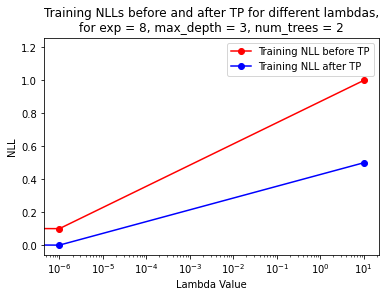

In [621]:
def plot_lmbda_vs_nll(lmbdas,nll_bt,nll_at,label_txt,exp,max_depth,num_trees):
  '''
  plot only for different lambdas and one max depth and one num trees
  '''
  fig,ax=plt.subplots()
  ax.set_xlabel("Lambda Value")
  ax.set_ylabel("NLL")
  #ax.set_xscale('log')
  ax.semilogx(lmbdas, nll_bt,'-ro',lmbdas, nll_at,'-bo')
  #plt.title(label_txt+' NLLs before and after TP for different '+r'$\lambda \n')
  plt.title(label_txt+' NLLs before and after TP for different lambdas,\nfor exp = '+str(exp)+', max_depth = '+str(max_depth)+', num_trees = '+str(num_trees))
  plt.legend([label_txt+" NLL before TP",label_txt+" NLL after TP"],prop={'size': 10})
  plt.show()

# an example
plot_lmbda_vs_nll([0,10**-6,10],[1,0.1,1],[1.2,0,0.5],'Training',8,3,2)

In [622]:
def plot_lmbda_vs_nll_diff_depth_num_trees(lmbdas,exp,num_trees_dict):
  '''
  plot only for different lambdas and one max depth and one num trees
  '''
  fig, (ax, ax2) = plt.subplots(1, 2,figsize=(14,6))
  ax.set_xlabel("Lambda Value")
  ax.set_ylabel("NLL")

  ax2.set_xlabel("Lambda Value")
  ax2.set_ylabel("NLL")

  ax.set_title("NLL vs Lambda for Training data", loc='center')
  ax2.set_title("NLL vs Lambda for Testing data", loc='center')

  colors_dict = mcolors.TABLEAU_COLORS
  color_keys = list(colors_dict.keys())
  color_index = 0
  for num_trees in num_trees_dict.keys():

    for max_depth in num_trees_dict[num_trees].keys():
      nll_train_bt, nll_train_at, nll_test_bt, nll_test_at = num_trees_dict[num_trees][max_depth]

      
      if(color_index==0): #bt values need to be plotted once, since they are the same for all trees and maxdepths
        c1 = colors_dict[color_keys[color_index]]  
        ax.semilogx(lmbdas, nll_train_bt,color=c1, linestyle='-', marker='o', label = 'Before Training')
        ax2.semilogx(lmbdas, nll_test_bt,color=c1, linestyle='-', marker='o')
        color_index += 1
      
      c2 = colors_dict[color_keys[color_index]]  
      ax.semilogx(lmbdas, nll_train_at,color=c2, linestyle='-', marker='o',label = 'After Training for \n max_depth = '+str(max_depth)+', num_trees = '+str(num_trees))   
      ax2.semilogx(lmbdas, nll_test_at,color=c2, linestyle='-', marker='o')
      
      color_index += 1

  lines_labels = [axs.get_legend_handles_labels() for axs in fig.axes]
  lines, labels = [sum(l, []) for l in zip(*lines_labels)]

  # finally we invoke the legend (that you probably would like to customize...)
  fig.legend(lines, labels,loc="right", bbox_to_anchor=(1.2, 0.5))
  plt.tight_layout()
  plt.show()

# an example
#plot_lmbda_vs_nll_diff_depth_num_trees(lmbdas,8,num_trees_dict)

# Run Experiments

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0179
The average test time across 1 folds was 0.0003
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.7058972770101137
The average N

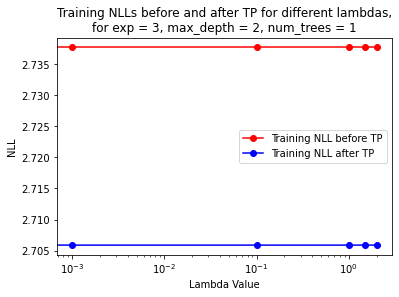

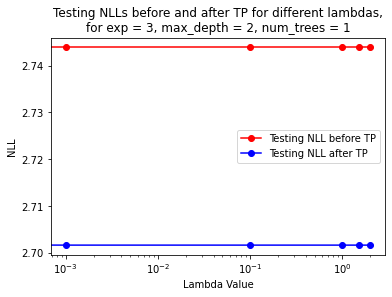

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0177
The average test time across 1 folds was 0.0007
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.6369493309007384
The average N

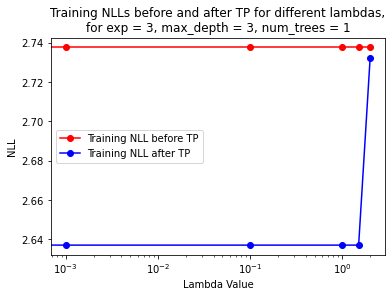

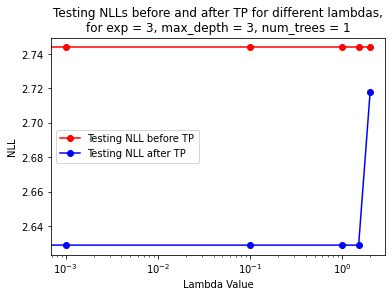

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0177
The average test time across 1 folds was 0.0014
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.662053190826963
The average NL

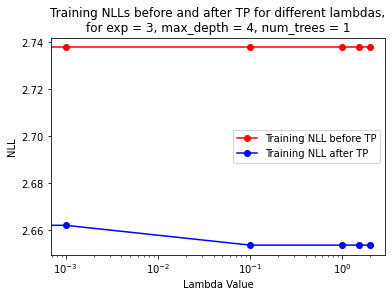

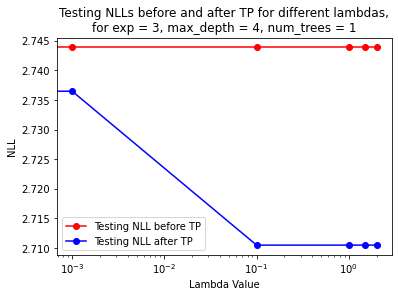

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0383
The average test time across 1 folds was 0.0006
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.6781881286887823
The average N

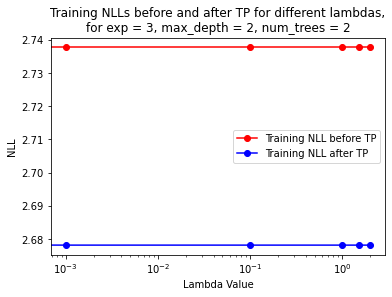

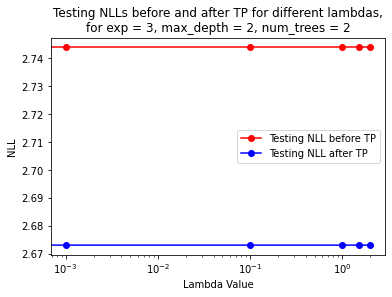

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.036
The average test time across 1 folds was 0.0017
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.6108084889727947
The average NL

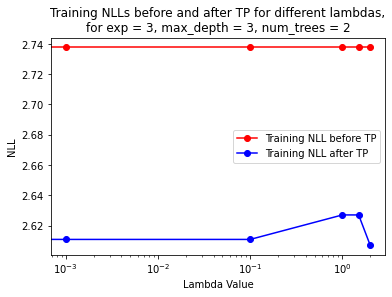

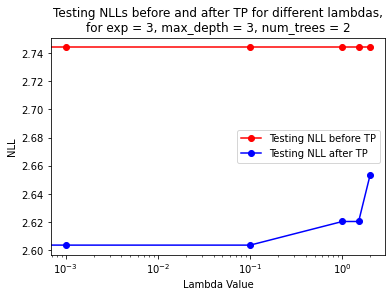

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0371
The average test time across 1 folds was 0.0006
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.657839905612094
The average NL

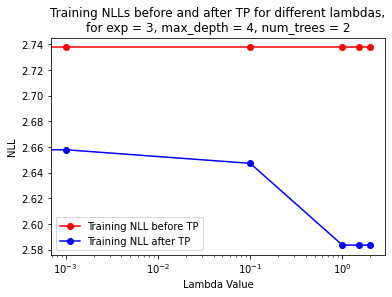

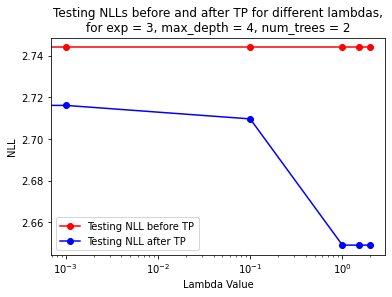

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0591
The average test time across 1 folds was 0.0021
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.6670477610014243
The average N

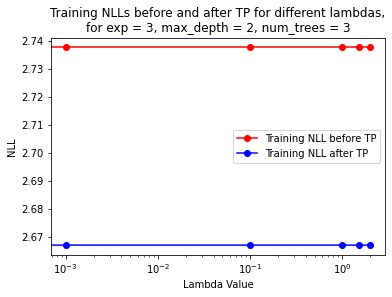

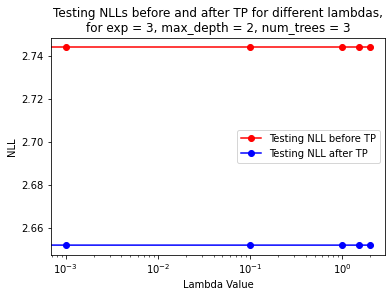

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0568
The average test time across 1 folds was 0.002
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.585825966308426
The average NLL

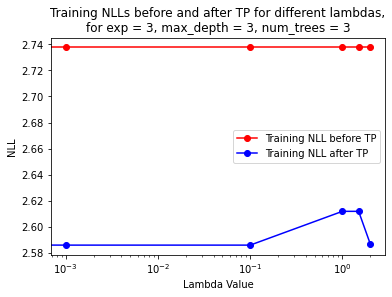

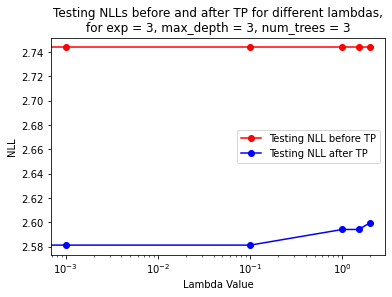

****For lambda = 0 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.737646309010534
The average NLL of the test data (before training) is 2.7438785695788988
The average NLL of the test data (after training) is 2.7438785695788988
BEFORE TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
AFTER TRAINING
The average training NLL across 1 folds was 2.7376
The average testing NLL across 1 folds was 2.7439
TRAINING AND TESTING TIMES
The average train time across 1 folds was 0.0557
The average test time across 1 folds was 0.0021
****For lambda = 0.001 ****
FOR FOLD: 0
Size of training data is 8000
Size of testing data is 2000
The average NLL of the train data (before training) is 2.737646309010534
The average NLL of the train data (after training) is 2.6383091787000197
The average N

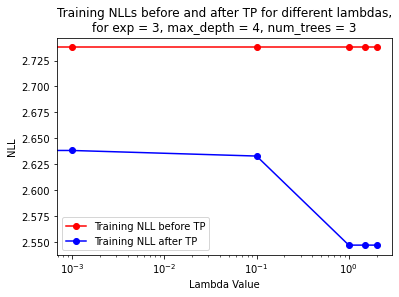

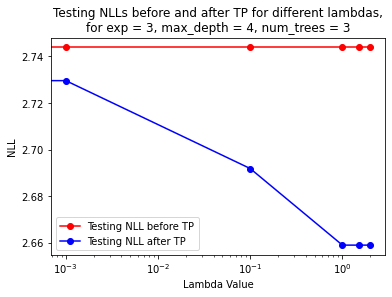

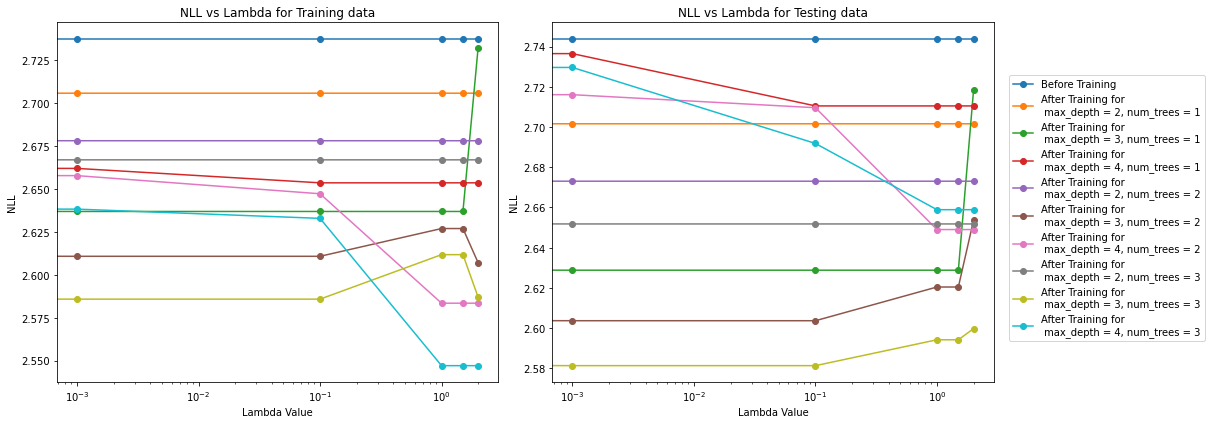

In [623]:
DEBUG = False
CALCULATE_INV = False
exp = 3
train_only = False
kfolds = 1
train_portion = 0.8 #to be used only when kfolds = 1 and train_only = False
alpha = 1
num_trees_list = [1,2,3]
if(exp==1):
  max_depth_list = [2]
  n_features = 2
  k = 2
  n_samples = 10000
  orig_probs=[1/3,1/6,1/6,1/3]
  is_manual_prob = True
  dr_seed = 0 #not used
  lmbdas = [1]
  lmbdas = [-10,-1,-0.001,0,0.001,1,10]
  syn_data = True
elif(exp==2):
  max_depth_list = [2]
  n_features = 2
  k = 2
  n_samples = 10000
  orig_probs=[1/8,3/8,3/8,1/8]
  is_manual_prob = True
  dr_seed = 0 #not used
  lmbdas = [1]
  syn_data = True
elif(exp==3):
  dr_seed = 0 #seed for the dirchlet dist.
  is_manual_prob = False
  k = 2
  max_depth_list = [2,3,4]
  n_features = 4
  n_samples = 10000
  lmbdas = [0.0001]
  lmbdas = [0, 10**-3, 10**-1, 1, 1.5, 2 ]
  syn_data = True
elif(exp==4):
  dr_seed = 0 #seed for the dirchlet dist.
  is_manual_prob = False
  k = 5
  max_depth_list = [5]
  n_features = 5
  n_samples = 10000
  lmbdas = [1]
  syn_data = True
elif(exp==5):
  dr_seed = 0 #seed for the dirchlet dist.
  is_manual_prob = False
  k = 5
  max_depth_list = [5]
  n_features = 10
  n_samples = 10000
  lmbdas = [1]
  syn_data = True
  lmbdas = [-10,-1,-0.001,0,0.001,1,10]
elif(exp==6):
  dr_seed = 0 #seed for the dirchlet dist.
  is_manual_prob = False
  k = 10
  max_depth_list = [5]
  n_features = 5
  n_samples = 10000
  lmbdas = [-10,-1,-0.001,0,0.001,1,10]
  syn_data = True
elif(exp == 7):
  syn_data = False
  data_orig = process_bike_sharing_data(bike_sharing_data_path)
  lmbdas = [1]
  n_samples, n_features = data_orig.shape
  max_depth_list = [5]
elif(exp == 8):
  syn_data = False
  data_orig = process_mushroom_data(mushroom_data_path)
  lmbdas = [-10,-1,-0.001,0,0.001,1,10]
  lmbdas = np.logspace(-10,-1, 10)
  lmbdas = [0, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1 ]
  n_samples, n_features = data_orig.shape
  max_depth_list = [2,3,4]

if(syn_data):
  orig_probs, coded_data = create_syn_data_paper(alpha,k=k,d=n_features,n_samples=n_samples,rnd_seed=42,manual_prob=is_manual_prob,orig_probs=orig_probs,dirchlet_seed=dr_seed)
if(DEBUG):
  print("original Probabilities are")
  print(orig_probs)

if(train_only==True and syn_data): #training only, no testing, limited exps
  data = dec_to_bin(coded_data,n_features=n_features,k=k) 
  sum_samples_log_prob,avg_samples_log_prob = compute_avg_nll_all(data)
  print("The average NLL of the data is "+str(avg_samples_log_prob))
  n,d = data.shape
  T = tree_perm(n) 
  indices = np.array(list(range(0,n)))
  tree_root =  construct_tree(T,data,indices,current_depth = 0,max_depth=max_depth,lmbda=lmbda)
  sum_samples_log_prob,avg_samples_log_prob = compute_avg_nll_all(data)
  print("The average NLL of the data (after training) is "+str(avg_samples_log_prob))
else: # main exps
  if(syn_data): # generate syn data if flad is True, other wise, data_orig is already filled with data
    data_orig = dec_to_bin(coded_data,n_features=n_features,k=k) 
  # I will plot for different values of num_trees
  num_trees_dict = {}
  # begin loop on num_trees
  for num_trees in num_trees_list:
    max_depth_dict = {}
    # I will plot for different values of max_depth
    # begin loop on max_depth 
    for max_depth in max_depth_list:
      # I will plot for different values of lambda
      avg_train_nll_lmbda_bt = []
      avg_test_nll_lmbda_bt = []
      avg_train_nll_lmbda = []
      avg_test_nll_lmbda = []
      #begin loop on lambdas
      for lmbda in lmbdas:
        print("****For lambda = "+str(lmbda)+" ****")
        total_train_bt_nll = 0
        total_test_bt_nll = 0
        total_train_nll = 0
        total_test_nll = 0
        total_train_time = 0
        total_test_time = 0
        for i in range(0,kfolds):
          print("FOR FOLD: "+str(i))
          data,test_data = create_X_train_test(data_orig,train_portion,kfolds,fold_num=i) 
          orig_data = data.copy() #I am keeping a copy of the original data to compare with the inverse
          print("Size of training data is "+str(data.shape[0]))
          print("Size of testing data is "+str(test_data.shape[0]))
          sum_samples_log_prob_train_bt,avg_samples_log_prob_train_bt = compute_avg_nll_all(data)
          sum_samples_log_prob_test_bt,avg_samples_log_prob_test_bt = compute_avg_nll_all(test_data)
          total_train_bt_nll+=avg_samples_log_prob_train_bt
          total_test_bt_nll+=avg_samples_log_prob_test_bt
          n,d = data.shape
          # if we have multiple trees, construct as many as specified
          trees = []
          for j in range(0,num_trees):
            trees.append(tree_perm(n)) 
          indices = np.array(list(range(0,n))) 
          tree_roots = []
          if(CALCULATE_INV):
            permuted_data = [orig_data] #the first data is unpermuted
          start_time = time.time()
          for j in range(0,num_trees):
            tree_root, max_node_id =  construct_tree(trees[j],data,indices,current_depth = 0,max_depth=max_depth,lmbda=lmbda)
            tree_roots.append(tree_root)
            # data is modified after the call to construct tree, I am just keeping a copy to
            # test that the inverse is working later on
            if(CALCULATE_INV):
              permuted_data.append(data.copy())
          end_time = time.time()
          total_train_time += end_time - start_time
          sum_samples_log_prob_train,avg_samples_log_prob_train = compute_avg_nll_all(data)
          print("The average NLL of the train data (before training) is "+str(avg_samples_log_prob_train_bt))
          print("The average NLL of the train data (after training) is "+str(avg_samples_log_prob_train))
          start_time = time.time()
          for j in range(0,num_trees):
            test_tree(trees[j],test_data)
            # test data is also modified after the call to test_tree
          end_time = time.time()
          total_test_time += end_time - start_time
          sum_samples_log_prob_test,avg_samples_log_prob_test = compute_avg_nll_all(test_data)
          print("The average NLL of the test data (before training) is "+str(avg_samples_log_prob_test_bt))
          print("The average NLL of the test data (after training) is "+str(avg_samples_log_prob_test))
          total_train_nll += avg_samples_log_prob_train # to calculate the avg across the folds
          total_test_nll += avg_samples_log_prob_test # to calculate the avg across the folds
          if(CALCULATE_INV):
            print("INVERSE CALCULATION")
            for j in range(-1,-num_trees-1,-1):
              inv_data = calculate_inverse(trees[j],permuted_data[j],permuted_data[j-1])
              if(DEBUG):
                print("Iverse for tree "+str(num_trees+j)+" is calculated and is : ")
                print((inv_data==permuted_data[j-1]).all())
            
            print("The inverse is calculated and is "+str((orig_data==inv_data).all())) #just checking that inverse is correct
          #end loop on kfolds
        avg_train_nll_bt = total_train_bt_nll/kfolds
        avg_test_nll_bt = total_test_bt_nll/kfolds
        avg_train_nll = total_train_nll/kfolds
        avg_test_nll = total_test_nll/kfolds
        
        avg_train_time = total_train_time/kfolds
        avg_test_time = total_test_time/kfolds
        print("BEFORE TRAINING")
        print("The average training NLL across "+str(kfolds)+" folds was "+str(round(avg_train_nll_bt,4)))
        print("The average testing NLL across "+str(kfolds)+" folds was "+str(round(avg_test_nll_bt,4)))
        print("AFTER TRAINING")
        print("The average training NLL across "+str(kfolds)+" folds was "+str(round(avg_train_nll,4)))
        print("The average testing NLL across "+str(kfolds)+" folds was "+str(round(avg_test_nll,4)))
        print("TRAINING AND TESTING TIMES")
        print("The average train time across "+str(kfolds)+" folds was "+str(round(avg_train_time,4)))
        print("The average test time across "+str(kfolds)+" folds was "+str(round(avg_test_time,4)))

        avg_train_nll_lmbda_bt.append(avg_train_nll_bt)
        avg_test_nll_lmbda_bt.append(avg_test_nll_bt)
        avg_train_nll_lmbda.append(avg_train_nll)
        avg_test_nll_lmbda.append(avg_test_nll)
        #end loop on lambdas
      if(len(lmbdas)>1):
        plot_lmbda_vs_nll(lmbdas,avg_train_nll_lmbda_bt,avg_train_nll_lmbda,"Training",exp,max_depth,num_trees)
        plot_lmbda_vs_nll(lmbdas,avg_test_nll_lmbda_bt,avg_test_nll_lmbda,"Testing",exp,max_depth,num_trees)
      
      max_depth_dict[max_depth] = (avg_train_nll_lmbda_bt,avg_train_nll_lmbda,avg_test_nll_lmbda_bt,avg_test_nll_lmbda)
      #end loop on max depth
    
    num_trees_dict[num_trees] = max_depth_dict
    #end loop on num_trees
  plot_lmbda_vs_nll_diff_depth_num_trees(lmbdas,exp,num_trees_dict)

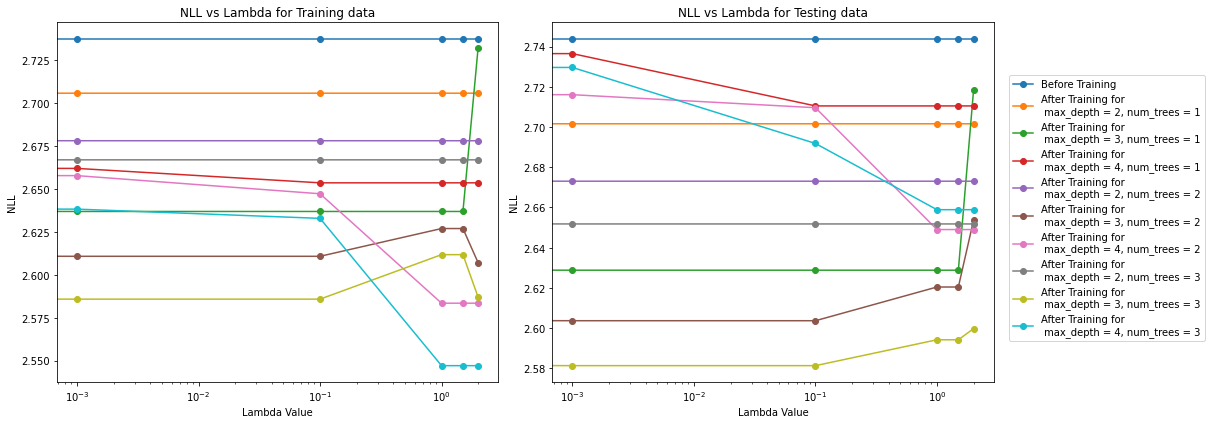

In [624]:
plot_lmbda_vs_nll_diff_depth_num_trees(lmbdas,8,num_trees_dict)

In [625]:
num_trees_dict

{1: {2: ([2.737646309010534,
    2.737646309010534,
    2.737646309010534,
    2.737646309010534,
    2.737646309010534,
    2.737646309010534],
   [2.737646309010534,
    2.7058972770101137,
    2.7058972770101137,
    2.7058972770101137,
    2.7058972770101137,
    2.7058972770101137],
   [2.7438785695788988,
    2.7438785695788988,
    2.7438785695788988,
    2.7438785695788988,
    2.7438785695788988,
    2.7438785695788988],
   [2.7438785695788988,
    2.7016104496414526,
    2.7016104496414526,
    2.7016104496414526,
    2.7016104496414526,
    2.7016104496414526]),
  3: ([2.737646309010534,
    2.737646309010534,
    2.737646309010534,
    2.737646309010534,
    2.737646309010534,
    2.737646309010534],
   [2.737646309010534,
    2.6369493309007384,
    2.6369493309007384,
    2.6369493309007384,
    2.6369493309007384,
    2.7324981668300943],
   [2.7438785695788988,
    2.7438785695788988,
    2.7438785695788988,
    2.7438785695788988,
    2.7438785695788988,
    2.74387856

In [626]:
# traverse the tree in the order in which nodes where created
for node in trees[0].order:
  print("Node "+str(node.id))
  print("Length of the node samples "+str(len(node.samples)))
  print("entropy and delta of the node are "+str(node.delta_and_entropy))
  print("split feature for the node's children is "+str(node.split_feature))
  print("split value for the node's children (left) is "+str(node.split_value))
  print("Node's perm feature "+str(node.perm_feature))
  print("Node's perm value "+str(node.perm_values))
  print("node depth is "+str(node.depth))
  if(node.is_perm_node):
    print("NODE IS A PERM NODE")
    #print("Perm values are "+str(node.perm_values))


Node 0
Length of the node samples 8000
entropy and delta of the node are 999998.011134481
split feature for the node's children is 0
split value for the node's children (left) is 0
Node's perm feature None
Node's perm value None
node depth is 0
Node 2
Length of the node samples 4287
entropy and delta of the node are -2.0272788094549963
split feature for the node's children is 1
split value for the node's children (left) is 0
Node's perm feature 3
Node's perm value [0, 1]
node depth is 1
NODE IS A PERM NODE
Node 1
Length of the node samples 3713
entropy and delta of the node are -1.8765122671436802
split feature for the node's children is 3
split value for the node's children (left) is 1
Node's perm feature 3
Node's perm value [0, 1]
node depth is 1
NODE IS A PERM NODE
Node 5
Length of the node samples 1269
entropy and delta of the node are -1.9053839981147553
split feature for the node's children is 1
split value for the node's children (left) is 0
Node's perm feature 2
Node's perm val